## VGG Models

In [18]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torch.optim as optim
from tqdm import tqdm

In [19]:
USE_GPU = True

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda


### Data Preparation

In [28]:
class VehicleDataset(Dataset):
    
    def __init__(self, path):
        data = np.load(path)
        self.images = data["images"]
        self.labels = data["labels"]
        print("Images shape:", self.images.shape)
        print("Labels shape:", self.labels.shape)
        self.__combinelabels__()

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)
        label = torch.tensor(label, dtype=torch.long)

        #mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        #std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        #image = (image - mean) / std
        
        return image, label
    def __combinelabels__(self):
        for idx, label in enumerate(self.labels):
            if label == 1:
                self.labels[idx] = 1
            if label >= 2 and label <= 7:
                self.labels[idx] = 2
            if label >= 8 and label <= 11:
                self.labels[idx] = 3
            if label >= 12 and label <= 25:
                self.labels[idx] = 4
            if label >= 26 and label <= 38:
               self.labels[idx] = 5
            if label >= 39 and label <= 44:
                self.labels[idx] = 6
            if label >= 45 and label <= 50:
                self.labels[idx] = 7
            if label >= 51 and label <= 53:
                self.labels[idx] = 8
            if label >= 54 and label <= 75:
                self.labels[idx] = 9
            if label >= 76 and label <= 81:
                self.labels[idx] = 10
            if label == 82:
                self.labels[idx] = 11
            if label >= 83 and label <= 97:
                self.labels[idx] = 12
            if label == 98:
                self.labels[idx] = 13
            if label >= 99 and label <= 100:
                self.labels[idx] = 14
            if label >= 101 and label <= 104:
                self.labels[idx] = 15
            if label == 105:
                self.labels[idx] = 16
            if label >= 106 and label <= 117:
                self.labels[idx] = 17
            if label >= 118 and label <= 122:
                self.labels[idx] = 18
            if label == 123:
                self.labels[idx] = 19
            if label >= 124 and label <= 125:
                self.labels[idx] = 20
            if label >= 126 and label <= 129:
                self.labels[idx] = 21
            if label >= 130 and label <= 140:
                self.labels[idx] = 22
            if label >= 141 and label <= 142:
                self.labels[idx] = 23
            if label == 143:
                self.labels[idx] = 24
            if label == 144:
                self.labels[idx] = 25
            if label >= 145 and label <= 149:
                self.labels[idx] = 26
            if label >= 150 and label <= 153:
                self.labels[idx] = 27
            if label >= 154 and label <= 155:
                self.labels[idx] = 28
            if label == 156:
                self.labels[idx] = 29
            if label == 157:
                self.labels[idx] = 30
            if label == 158:
                self.labels[idx] = 31
            if label == 159:
                self.labels[idx] = 32
            if label == 160:
                self.labels[idx] = 33
            if label >= 161 and label <= 166:
                self.labels[idx] = 34
            if label == 167:
                self.labels[idx] = 35
            if label >= 168 and label <= 171:
                self.labels[idx] = 36
            if label == 172:
                self.labels[idx] = 37
            if label == 173:
                self.labels[idx] = 38
            if label == 174:
                self.labels[idx] = 39
            if label >= 175 and label <= 177:
                self.labels[idx] = 40
            if label == 178:
                self.labels[idx] = 41
            if label >= 179 and label <= 180:
                self.labels[idx] = 42
            if label >= 181 and label <= 184:
                self.labels[idx] = 43
            if label == 185:
                self.labels[idx] = 44
            if label >= 186 and label <= 189:
                self.labels[idx] = 45
            if label >= 190 and label <= 192:
                self.labels[idx] = 46
            if label >= 193 and label <= 195:
                self.labels[idx] = 47
            if label == 196:
                self.labels[idx] = 48

In [29]:
dataset = VehicleDataset('../dataset/stanford_cars_dataset.npz')

batch_size = 32
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = int(len(dataset) - train_size - val_size)

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Images shape: (8144, 112, 112, 3)
Labels shape: (8144, 1)


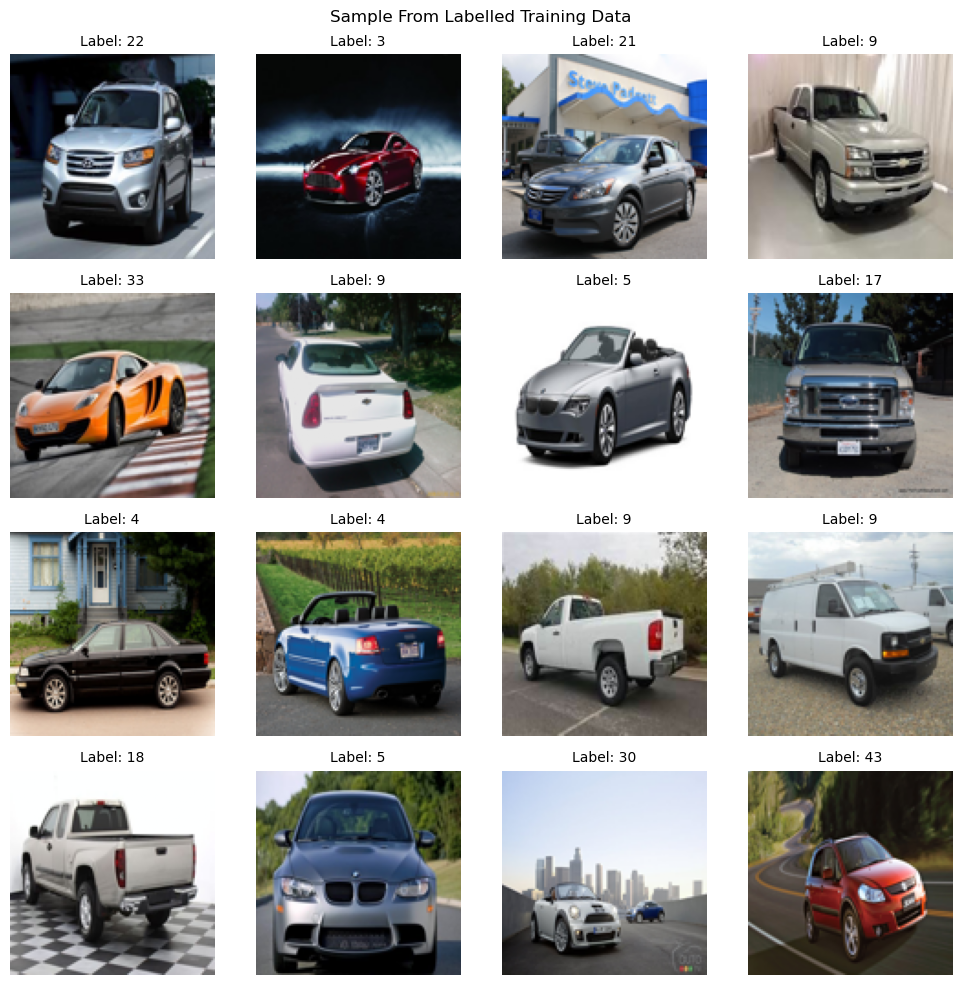

In [30]:
for images, labels in train_loader:
    break 

# Create figure
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
axes = axes.flatten()

for i in range(16):
    img = images[i].permute(1, 2, 0).numpy() 
    axes[i].imshow(img)
    axes[i].set_title(f"Label: {labels[i].item()}", fontsize=10)
    axes[i].axis("off")

plt.suptitle("Sample From Labelled Training Data")
plt.tight_layout(rect=[0, 0, 1, 1]) 
plt.show()

### VGG Models

In [31]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(BasicBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        return x

In [32]:
class VGG11(nn.Module):
    def __init__(self):
        super(VGG11, self).__init__()
        self.layer1 = BasicBlock(3, 112)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.layer2 = BasicBlock(112, 128)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.layer3 = BasicBlock(128, 256)
        self.layer4 = BasicBlock(256, 256)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.layer5 = BasicBlock(256, 512)
        self.layer6 = BasicBlock(512, 512)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.layer7 = BasicBlock(512, 512)
        self.layer8 = BasicBlock(512, 512)
        self.maxpool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.classifier = nn.Sequential(
            nn.Linear(4608, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 48)
        )
    def forward(self, x):
        x = self.layer1(x)
        x = self.maxpool1(x)
        x = self.layer2(x)
        x = self.maxpool2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.maxpool3(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.maxpool4(x)
        x = self.layer7(x)
        x = self.layer8(x)
        x = self.maxpool5(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

### Training

In [43]:
def train_model(model):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    # optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    num_epochs = 30
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
    
        for images, labels in tqdm(train_loader):
            images = images.to(device)
            labels = labels[:,0].to(device) - 1

            # Forward
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Metrics
            running_loss += loss.item() * images.size(0)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss / total
        epoch_acc = correct / total
        scheduler.step()
        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f} - Accuracy: {epoch_acc:.4f}")
    
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels[:,0].to(device) - 1
            
                outputs = model(images)
                preds = torch.argmax(outputs, dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        val_acc = correct / total
        print(f'Validation Acc: {val_acc:.4f}')

In [44]:
model = VGG11().to(device)
train_model(model)

100%|██████████| 179/179 [00:10<00:00, 17.06it/s]


Epoch 1/30 - Loss: 3.4905 - Accuracy: 0.1067
Validation Acc: 0.0989


100%|██████████| 179/179 [00:10<00:00, 17.02it/s]


Epoch 2/30 - Loss: 3.4552 - Accuracy: 0.1139
Validation Acc: 0.0989


100%|██████████| 179/179 [00:10<00:00, 17.01it/s]


Epoch 3/30 - Loss: 3.4484 - Accuracy: 0.1146
Validation Acc: 0.0989


100%|██████████| 179/179 [00:10<00:00, 17.00it/s]


Epoch 4/30 - Loss: 3.4361 - Accuracy: 0.1142
Validation Acc: 0.0989


100%|██████████| 179/179 [00:10<00:00, 16.99it/s]


Epoch 5/30 - Loss: 3.4305 - Accuracy: 0.1146
Validation Acc: 0.0989


100%|██████████| 179/179 [00:10<00:00, 16.93it/s]


Epoch 6/30 - Loss: 3.4287 - Accuracy: 0.1149
Validation Acc: 0.0989


100%|██████████| 179/179 [00:10<00:00, 17.00it/s]


Epoch 7/30 - Loss: 3.4289 - Accuracy: 0.1153
Validation Acc: 0.1007


100%|██████████| 179/179 [00:10<00:00, 17.02it/s]


Epoch 8/30 - Loss: 3.4016 - Accuracy: 0.1181
Validation Acc: 0.1026


100%|██████████| 179/179 [00:10<00:00, 17.09it/s]


Epoch 9/30 - Loss: 3.3731 - Accuracy: 0.1221
Validation Acc: 0.1198


100%|██████████| 179/179 [00:10<00:00, 17.00it/s]


Epoch 10/30 - Loss: 3.3395 - Accuracy: 0.1311
Validation Acc: 0.1327


100%|██████████| 179/179 [00:10<00:00, 16.96it/s]


Epoch 11/30 - Loss: 3.2632 - Accuracy: 0.1398
Validation Acc: 0.1265


100%|██████████| 179/179 [00:10<00:00, 17.00it/s]


Epoch 12/30 - Loss: 3.2469 - Accuracy: 0.1453
Validation Acc: 0.1296


100%|██████████| 179/179 [00:10<00:00, 17.05it/s]


Epoch 13/30 - Loss: 3.2319 - Accuracy: 0.1440
Validation Acc: 0.1308


100%|██████████| 179/179 [00:10<00:00, 16.79it/s]


Epoch 14/30 - Loss: 3.2224 - Accuracy: 0.1479
Validation Acc: 0.1290


100%|██████████| 179/179 [00:10<00:00, 16.96it/s]


Epoch 15/30 - Loss: 3.2100 - Accuracy: 0.1470
Validation Acc: 0.1296


100%|██████████| 179/179 [00:10<00:00, 17.00it/s]


Epoch 16/30 - Loss: 3.1948 - Accuracy: 0.1465
Validation Acc: 0.1308


100%|██████████| 179/179 [00:10<00:00, 17.12it/s]


Epoch 17/30 - Loss: 3.1838 - Accuracy: 0.1512
Validation Acc: 0.1351


100%|██████████| 179/179 [00:10<00:00, 17.00it/s]


Epoch 18/30 - Loss: 3.1723 - Accuracy: 0.1556
Validation Acc: 0.1400


100%|██████████| 179/179 [00:10<00:00, 16.97it/s]


Epoch 19/30 - Loss: 3.1584 - Accuracy: 0.1547
Validation Acc: 0.1376


100%|██████████| 179/179 [00:10<00:00, 16.92it/s]


Epoch 20/30 - Loss: 3.1412 - Accuracy: 0.1595
Validation Acc: 0.1407


100%|██████████| 179/179 [00:10<00:00, 17.05it/s]


Epoch 21/30 - Loss: 3.1197 - Accuracy: 0.1595
Validation Acc: 0.1407


100%|██████████| 179/179 [00:10<00:00, 17.01it/s]


Epoch 22/30 - Loss: 3.1176 - Accuracy: 0.1593
Validation Acc: 0.1394


100%|██████████| 179/179 [00:10<00:00, 16.88it/s]


Epoch 23/30 - Loss: 3.1155 - Accuracy: 0.1616
Validation Acc: 0.1388


100%|██████████| 179/179 [00:10<00:00, 16.96it/s]


Epoch 24/30 - Loss: 3.1099 - Accuracy: 0.1609
Validation Acc: 0.1400


100%|██████████| 179/179 [00:10<00:00, 16.99it/s]


Epoch 25/30 - Loss: 3.1129 - Accuracy: 0.1600
Validation Acc: 0.1413


100%|██████████| 179/179 [00:10<00:00, 16.97it/s]


Epoch 26/30 - Loss: 3.1091 - Accuracy: 0.1618
Validation Acc: 0.1413


100%|██████████| 179/179 [00:10<00:00, 16.94it/s]


Epoch 27/30 - Loss: 3.1075 - Accuracy: 0.1628
Validation Acc: 0.1413


100%|██████████| 179/179 [00:10<00:00, 16.93it/s]


Epoch 28/30 - Loss: 3.1035 - Accuracy: 0.1605
Validation Acc: 0.1413


100%|██████████| 179/179 [00:10<00:00, 16.91it/s]


Epoch 29/30 - Loss: 3.1033 - Accuracy: 0.1588
Validation Acc: 0.1413


100%|██████████| 179/179 [00:10<00:00, 16.82it/s]


Epoch 30/30 - Loss: 3.1041 - Accuracy: 0.1640
Validation Acc: 0.1431


### Testing

In [45]:
def test_model(model, test_loader, device):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels[:,0].to(device) - 1 
            
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())

    accuracy = correct / total
    print(f'Test Accuracy: {accuracy:.4f}')

    # Concatenate all predictions and labels if needed for further analysis
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    
    return accuracy, all_preds, all_labels

In [46]:
test_model(model, test_loader, device)

Test Accuracy: 0.1483


(0.1482843137254902,
 tensor([ 3,  3,  8,  3, 26,  8,  8,  8, 11,  8,  8,  8,  3,  3, 11,  8,  4,  3,
          3,  8,  8,  3,  8,  8,  8,  8,  8, 11,  3,  8, 26,  8,  8, 11,  8,  3,
          4,  8,  3,  8,  8,  3,  8,  8,  3,  8, 26, 11, 11,  3,  8,  8,  8,  8,
          8,  8,  3,  3,  3,  3,  3, 11, 11,  8,  3,  8, 11,  3,  8,  5,  3, 11,
          8,  3,  8, 11,  8,  3,  3,  8, 11,  3,  8,  8, 11, 11,  8,  8,  8,  8,
          8,  3,  8,  4,  8, 11,  8,  8,  8,  8,  8,  3,  5,  8,  8,  8,  8,  8,
          8,  8, 11,  3, 11,  3,  8,  8,  8,  8,  8,  8,  8,  8,  8,  3,  3, 11,
          8,  3, 11,  8,  3,  3,  8,  3,  8,  8,  3,  4, 16,  3,  3,  3,  8, 26,
          8,  8, 11,  3,  8,  8, 11,  3,  8,  3, 11,  8,  3,  3,  3,  8,  3, 11,
          3,  8,  3,  3,  3,  3,  4,  3,  8,  3,  3,  8,  3,  8, 11,  8,  8, 11,
          3, 11, 11,  3,  8,  3,  3,  8,  8,  8,  8,  3,  3,  8,  8,  8, 11,  8,
         26,  8, 11, 11,  3,  3,  8,  4,  3,  8,  3, 16,  8,  8,  8,  8,  3, 11,
       

In [48]:
class VGG13(nn.Module):
    def __init__(self):
        super(VGG13, self).__init__()
        self.layer1 = BasicBlock(3, 64)
        self.layer11 = BasicBlock(64, 64)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.layer2 = BasicBlock(64, 128)
        self.layer22 = BasicBlock(128, 128)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.layer3 = BasicBlock(128, 256)
        self.layer4 = BasicBlock(256, 256)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.layer5 = BasicBlock(256, 512)
        self.layer6 = BasicBlock(512, 512)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.layer7 = BasicBlock(512, 512)
        self.layer8 = BasicBlock(512, 512)
        self.maxpool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.classifier = nn.Sequential(
            nn.Linear(4608, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 48)
        )
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer11(x)
        x = self.maxpool1(x)
        x = self.layer2(x)
        x = self.layer22(x)
        x = self.maxpool2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.maxpool3(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.maxpool4(x)
        x = self.layer7(x)
        x = self.layer8(x)
        x = self.maxpool5(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [49]:
model = VGG13().to(device)
train_model(model)

100%|██████████| 179/179 [00:11<00:00, 15.27it/s]


Epoch 1/30 - Loss: 3.5009 - Accuracy: 0.1077
Validation Acc: 0.0989


100%|██████████| 179/179 [00:11<00:00, 15.25it/s]


Epoch 2/30 - Loss: 3.4530 - Accuracy: 0.1132
Validation Acc: 0.0989


100%|██████████| 179/179 [00:11<00:00, 15.22it/s]


Epoch 3/30 - Loss: 3.4491 - Accuracy: 0.1140
Validation Acc: 0.0989


100%|██████████| 179/179 [00:11<00:00, 15.17it/s]


Epoch 4/30 - Loss: 3.4382 - Accuracy: 0.1153
Validation Acc: 0.0989


100%|██████████| 179/179 [00:11<00:00, 15.21it/s]


Epoch 5/30 - Loss: 3.4310 - Accuracy: 0.1153
Validation Acc: 0.0989


100%|██████████| 179/179 [00:11<00:00, 15.27it/s]


Epoch 6/30 - Loss: 3.4209 - Accuracy: 0.1139
Validation Acc: 0.0989


100%|██████████| 179/179 [00:11<00:00, 15.25it/s]


Epoch 7/30 - Loss: 3.4171 - Accuracy: 0.1144
Validation Acc: 0.0983


100%|██████████| 179/179 [00:11<00:00, 15.19it/s]


Epoch 8/30 - Loss: 3.3979 - Accuracy: 0.1184
Validation Acc: 0.1179


100%|██████████| 179/179 [00:11<00:00, 15.20it/s]


Epoch 9/30 - Loss: 3.3624 - Accuracy: 0.1368
Validation Acc: 0.1081


100%|██████████| 179/179 [00:11<00:00, 15.15it/s]


Epoch 10/30 - Loss: 3.3245 - Accuracy: 0.1421
Validation Acc: 0.1364


100%|██████████| 179/179 [00:11<00:00, 15.18it/s]


Epoch 11/30 - Loss: 3.2558 - Accuracy: 0.1533
Validation Acc: 0.1468


100%|██████████| 179/179 [00:11<00:00, 15.00it/s]


Epoch 12/30 - Loss: 3.2343 - Accuracy: 0.1561
Validation Acc: 0.1474


100%|██████████| 179/179 [00:11<00:00, 15.16it/s]


Epoch 13/30 - Loss: 3.2208 - Accuracy: 0.1544
Validation Acc: 0.1443


100%|██████████| 179/179 [00:11<00:00, 15.21it/s]


Epoch 14/30 - Loss: 3.2045 - Accuracy: 0.1600
Validation Acc: 0.1443


100%|██████████| 179/179 [00:11<00:00, 15.18it/s]


Epoch 15/30 - Loss: 3.1912 - Accuracy: 0.1581
Validation Acc: 0.1493


100%|██████████| 179/179 [00:11<00:00, 15.08it/s]


Epoch 16/30 - Loss: 3.1814 - Accuracy: 0.1607
Validation Acc: 0.1493


100%|██████████| 179/179 [00:11<00:00, 15.17it/s]


Epoch 17/30 - Loss: 3.1684 - Accuracy: 0.1642
Validation Acc: 0.1480


100%|██████████| 179/179 [00:11<00:00, 15.15it/s]


Epoch 18/30 - Loss: 3.1536 - Accuracy: 0.1670
Validation Acc: 0.1499


100%|██████████| 179/179 [00:11<00:00, 15.15it/s]


Epoch 19/30 - Loss: 3.1385 - Accuracy: 0.1693
Validation Acc: 0.1529


100%|██████████| 179/179 [00:11<00:00, 15.20it/s]


Epoch 20/30 - Loss: 3.1272 - Accuracy: 0.1707
Validation Acc: 0.1493


100%|██████████| 179/179 [00:11<00:00, 15.10it/s]


Epoch 21/30 - Loss: 3.1045 - Accuracy: 0.1765
Validation Acc: 0.1517


100%|██████████| 179/179 [00:11<00:00, 15.14it/s]


Epoch 22/30 - Loss: 3.1043 - Accuracy: 0.1749
Validation Acc: 0.1511


100%|██████████| 179/179 [00:11<00:00, 15.25it/s]


Epoch 23/30 - Loss: 3.0986 - Accuracy: 0.1737
Validation Acc: 0.1493


100%|██████████| 179/179 [00:11<00:00, 15.15it/s]


Epoch 24/30 - Loss: 3.0977 - Accuracy: 0.1765
Validation Acc: 0.1480


100%|██████████| 179/179 [00:11<00:00, 15.15it/s]


Epoch 25/30 - Loss: 3.0937 - Accuracy: 0.1781
Validation Acc: 0.1480


100%|██████████| 179/179 [00:11<00:00, 15.16it/s]


Epoch 26/30 - Loss: 3.0967 - Accuracy: 0.1746
Validation Acc: 0.1499


100%|██████████| 179/179 [00:11<00:00, 15.09it/s]


Epoch 27/30 - Loss: 3.0939 - Accuracy: 0.1761
Validation Acc: 0.1511


100%|██████████| 179/179 [00:11<00:00, 15.21it/s]


Epoch 28/30 - Loss: 3.0917 - Accuracy: 0.1774
Validation Acc: 0.1480


100%|██████████| 179/179 [00:11<00:00, 15.15it/s]


Epoch 29/30 - Loss: 3.0847 - Accuracy: 0.1774
Validation Acc: 0.1505


100%|██████████| 179/179 [00:11<00:00, 15.09it/s]


Epoch 30/30 - Loss: 3.0861 - Accuracy: 0.1765
Validation Acc: 0.1493


In [50]:
test_model(model, test_loader, device)

Test Accuracy: 0.1495


(0.14950980392156862,
 tensor([ 3,  3, 11,  8, 26, 26,  8,  8, 11,  8,  8,  8,  4,  8,  8,  8,  8,  3,
          8,  8,  8,  3,  8,  8,  8,  8,  8,  8,  4,  8,  8,  8,  8, 11,  8,  3,
          4,  8,  3,  8,  8,  3,  8, 11,  3,  8,  8,  8, 11,  4,  8,  8,  8,  8,
         26,  8,  4,  8,  3,  3,  3,  4, 11, 11,  3,  8,  4,  8,  8,  5,  3,  8,
          8,  3,  8, 11,  8,  3,  3,  8, 11,  5,  8,  8,  8,  8,  8,  8,  8,  8,
          8,  3,  8,  5,  8, 11,  8,  8,  8,  8,  8,  8,  3,  8,  8,  8,  8,  8,
          8,  8,  8,  3, 11,  8,  8,  8,  8,  8,  3, 11,  8,  8,  8,  3, 11,  8,
          8,  8, 11,  8, 11,  3,  8,  3,  8,  4,  4,  3,  8,  3,  3,  3, 11,  3,
          8,  8,  8, 11,  8,  8,  8,  3,  8,  3,  8,  8,  3,  4,  3,  8,  3, 11,
          3,  8, 26,  8,  3,  3,  5,  3,  3, 11,  3,  8,  3,  8,  3,  8, 11, 11,
          5, 11, 11,  4,  8,  8,  3,  8, 11,  4,  8, 11,  3,  8,  8,  8, 11,  8,
          8,  8,  8, 11,  3,  4,  8,  4,  3,  8,  4,  8,  8,  8, 11,  5,  3,  8,
      

In [52]:
class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        self.layer1 = BasicBlock(3, 64)
        self.layer11 = BasicBlock(64, 64)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.layer2 = BasicBlock(64, 128)
        self.layer22 = BasicBlock(128, 128)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.layer3 = BasicBlock(128, 256)
        self.layer4 = BasicBlock(256, 256)
        self.layer41 = BasicBlock(256, 256)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.layer5 = BasicBlock(256, 512)
        self.layer6 = BasicBlock(512, 512)
        self.layer61 = BasicBlock(512, 512)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.layer7 = BasicBlock(512, 512)
        self.layer8 = BasicBlock(512, 512)
        self.layer81 = BasicBlock(512, 512)
        self.maxpool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.classifier = nn.Sequential(
            nn.Linear(4608, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 48)
        )
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer11(x)
        x = self.maxpool1(x)
        x = self.layer2(x)
        x = self.layer22(x)
        x = self.maxpool2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer41(x)
        x = self.maxpool3(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.layer61(x)
        x = self.maxpool4(x)
        x = self.layer7(x)
        x = self.layer8(x)
        x = self.layer81(x)
        x = self.maxpool5(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [53]:
model = VGG16().to(device)
train_model(model)

100%|██████████| 179/179 [00:13<00:00, 12.81it/s]


Epoch 1/30 - Loss: 3.4960 - Accuracy: 0.1005
Validation Acc: 0.0989


100%|██████████| 179/179 [00:13<00:00, 12.85it/s]


Epoch 2/30 - Loss: 3.4567 - Accuracy: 0.1132
Validation Acc: 0.0989


100%|██████████| 179/179 [00:13<00:00, 12.85it/s]


Epoch 3/30 - Loss: 3.4615 - Accuracy: 0.1144
Validation Acc: 0.0989


100%|██████████| 179/179 [00:13<00:00, 12.88it/s]


Epoch 4/30 - Loss: 3.4393 - Accuracy: 0.1140
Validation Acc: 0.0989


100%|██████████| 179/179 [00:13<00:00, 12.79it/s]


Epoch 5/30 - Loss: 3.4339 - Accuracy: 0.1149
Validation Acc: 0.0989


100%|██████████| 179/179 [00:13<00:00, 12.83it/s]


Epoch 6/30 - Loss: 3.4310 - Accuracy: 0.1151
Validation Acc: 0.0989


100%|██████████| 179/179 [00:14<00:00, 12.71it/s]


Epoch 7/30 - Loss: 3.4209 - Accuracy: 0.1153
Validation Acc: 0.0989


100%|██████████| 179/179 [00:14<00:00, 12.70it/s]


Epoch 8/30 - Loss: 3.4118 - Accuracy: 0.1146
Validation Acc: 0.0989


100%|██████████| 179/179 [00:14<00:00, 12.69it/s]


Epoch 9/30 - Loss: 3.3951 - Accuracy: 0.1154
Validation Acc: 0.1057


100%|██████████| 179/179 [00:14<00:00, 12.72it/s]


Epoch 10/30 - Loss: 3.3626 - Accuracy: 0.1170
Validation Acc: 0.1112


100%|██████████| 179/179 [00:13<00:00, 12.83it/s]


Epoch 11/30 - Loss: 3.3235 - Accuracy: 0.1316
Validation Acc: 0.1278


100%|██████████| 179/179 [00:13<00:00, 12.79it/s]


Epoch 12/30 - Loss: 3.2945 - Accuracy: 0.1344
Validation Acc: 0.1321


100%|██████████| 179/179 [00:14<00:00, 12.77it/s]


Epoch 13/30 - Loss: 3.2838 - Accuracy: 0.1328
Validation Acc: 0.1314


100%|██████████| 179/179 [00:13<00:00, 12.81it/s]


Epoch 14/30 - Loss: 3.2736 - Accuracy: 0.1325
Validation Acc: 0.1308


100%|██████████| 179/179 [00:14<00:00, 12.78it/s]


Epoch 15/30 - Loss: 3.2612 - Accuracy: 0.1316
Validation Acc: 0.1339


100%|██████████| 179/179 [00:14<00:00, 12.75it/s]


Epoch 16/30 - Loss: 3.2546 - Accuracy: 0.1382
Validation Acc: 0.1364


100%|██████████| 179/179 [00:14<00:00, 12.78it/s]


Epoch 17/30 - Loss: 3.2466 - Accuracy: 0.1384
Validation Acc: 0.1314


100%|██████████| 179/179 [00:14<00:00, 12.75it/s]


Epoch 18/30 - Loss: 3.2399 - Accuracy: 0.1404
Validation Acc: 0.1327


100%|██████████| 179/179 [00:14<00:00, 12.76it/s]


Epoch 19/30 - Loss: 3.2270 - Accuracy: 0.1430
Validation Acc: 0.1382


100%|██████████| 179/179 [00:13<00:00, 12.81it/s]


Epoch 20/30 - Loss: 3.2225 - Accuracy: 0.1391
Validation Acc: 0.1376


100%|██████████| 179/179 [00:14<00:00, 12.78it/s]


Epoch 21/30 - Loss: 3.2078 - Accuracy: 0.1451
Validation Acc: 0.1370


100%|██████████| 179/179 [00:14<00:00, 12.78it/s]


Epoch 22/30 - Loss: 3.2047 - Accuracy: 0.1486
Validation Acc: 0.1394


100%|██████████| 179/179 [00:13<00:00, 12.79it/s]


Epoch 23/30 - Loss: 3.2037 - Accuracy: 0.1474
Validation Acc: 0.1370


100%|██████████| 179/179 [00:13<00:00, 12.81it/s]


Epoch 24/30 - Loss: 3.2000 - Accuracy: 0.1479
Validation Acc: 0.1364


100%|██████████| 179/179 [00:13<00:00, 12.85it/s]


Epoch 25/30 - Loss: 3.2018 - Accuracy: 0.1461
Validation Acc: 0.1382


100%|██████████| 179/179 [00:13<00:00, 12.82it/s]


Epoch 26/30 - Loss: 3.2002 - Accuracy: 0.1439
Validation Acc: 0.1376


100%|██████████| 179/179 [00:14<00:00, 12.74it/s]


Epoch 27/30 - Loss: 3.1985 - Accuracy: 0.1446
Validation Acc: 0.1370


100%|██████████| 179/179 [00:14<00:00, 12.75it/s]


Epoch 28/30 - Loss: 3.1996 - Accuracy: 0.1412
Validation Acc: 0.1370


100%|██████████| 179/179 [00:14<00:00, 12.78it/s]


Epoch 29/30 - Loss: 3.1970 - Accuracy: 0.1442
Validation Acc: 0.1376


100%|██████████| 179/179 [00:14<00:00, 12.57it/s]


Epoch 30/30 - Loss: 3.1958 - Accuracy: 0.1475
Validation Acc: 0.1388


In [54]:
test_model(model, test_loader, device)

Test Accuracy: 0.1458


(0.14583333333333334,
 tensor([ 3,  3,  8,  8, 26,  8,  8,  8,  3,  8,  8,  8,  8,  8, 11,  8,  4,  3,
         11,  8,  8,  8,  8,  8,  3,  8,  8,  8,  3,  8, 26,  8,  8, 11, 26,  8,
          3,  8,  3,  3,  8,  3,  8, 11,  3,  8, 26, 11, 11,  8,  8,  8,  8,  8,
          8,  8,  8,  3,  3,  4,  3,  3, 11,  8,  3,  8,  3,  8,  8,  3,  4,  8,
          3,  4,  8, 11,  8,  3,  3,  8,  4,  8,  8,  8,  8, 11,  8,  8,  8,  8,
          3,  3,  8,  3,  8, 11,  8,  8,  8,  8,  8,  8,  3,  8,  8,  8,  8,  8,
          8,  8,  8,  3, 11,  8,  8,  8,  8,  8,  3,  8,  8,  8,  8,  4,  3,  8,
          8,  3, 11,  8,  3,  3,  8,  3,  8,  8,  3,  3, 11,  3,  3,  3,  8, 26,
         11,  8,  8,  4,  8,  8, 11,  3,  8,  3,  8, 26,  8,  3,  3, 11,  3, 11,
          3,  8,  3,  4, 11,  3,  8,  3,  3,  3,  3, 26,  3,  8,  3,  8,  8, 11,
          3,  8, 11,  8,  8,  8,  3,  8,  8,  3,  8, 11,  4,  8,  8,  8,  8,  8,
          8,  8, 11, 11,  3,  8,  8,  8, 11,  8,  3,  8,  8, 26,  8,  8,  3,  8,
      

In [58]:
class VGG19(nn.Module):
    def __init__(self):
        super(VGG19, self).__init__()
        self.layer1 = BasicBlock(3, 64)
        self.layer11 = BasicBlock(64, 64)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.layer2 = BasicBlock(64, 128)
        self.layer22 = BasicBlock(128, 128)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.layer3 = BasicBlock(128, 256)
        self.layer4 = BasicBlock(256, 256)
        self.layer41 = BasicBlock(256, 256)
        self.layer42 = BasicBlock(256, 256)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.layer5 = BasicBlock(256, 512)
        self.layer6 = BasicBlock(512, 512)
        self.layer61 = BasicBlock(512, 512)
        self.layer62 = BasicBlock(512, 512)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.layer7 = BasicBlock(512, 512)
        self.layer8 = BasicBlock(512, 512)
        self.layer81 = BasicBlock(512, 512)
        self.layer82 = BasicBlock(512, 512)
        self.maxpool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.classifier = nn.Sequential(
            nn.Linear(4608, 4096),
            nn.ReLU(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, 48)
        )
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer11(x)
        x = self.maxpool1(x)
        x = self.layer2(x)
        x = self.layer22(x)
        x = self.maxpool2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer41(x)
        x = self.layer42(x)
        x = self.maxpool3(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.layer61(x)
        x = self.layer62(x)
        x = self.maxpool4(x)
        x = self.layer7(x)
        x = self.layer8(x)
        x = self.layer81(x)
        x = self.layer82(x)
        x = self.maxpool5(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [59]:
model = VGG19().to(device)
train_model(model)

100%|██████████| 179/179 [00:16<00:00, 10.93it/s]


Epoch 1/30 - Loss: 3.5458 - Accuracy: 0.1058
Validation Acc: 0.0989


100%|██████████| 179/179 [00:16<00:00, 11.12it/s]


Epoch 2/30 - Loss: 3.4435 - Accuracy: 0.1151
Validation Acc: 0.0989


100%|██████████| 179/179 [00:16<00:00, 11.09it/s]


Epoch 3/30 - Loss: 3.4341 - Accuracy: 0.1151
Validation Acc: 0.0989


100%|██████████| 179/179 [00:16<00:00, 10.87it/s]


Epoch 4/30 - Loss: 3.4268 - Accuracy: 0.1151
Validation Acc: 0.0989


100%|██████████| 179/179 [00:16<00:00, 10.79it/s]


Epoch 5/30 - Loss: 3.4257 - Accuracy: 0.1151
Validation Acc: 0.0989


100%|██████████| 179/179 [00:16<00:00, 10.90it/s]


Epoch 6/30 - Loss: 3.4262 - Accuracy: 0.1151
Validation Acc: 0.0989


100%|██████████| 179/179 [00:16<00:00, 10.92it/s]


Epoch 7/30 - Loss: 3.4252 - Accuracy: 0.1151
Validation Acc: 0.0989


100%|██████████| 179/179 [00:16<00:00, 11.08it/s]


Epoch 8/30 - Loss: 3.4259 - Accuracy: 0.1151
Validation Acc: 0.0989


100%|██████████| 179/179 [00:16<00:00, 11.05it/s]


Epoch 9/30 - Loss: 3.4226 - Accuracy: 0.1151
Validation Acc: 0.1007


100%|██████████| 179/179 [00:16<00:00, 11.09it/s]


Epoch 10/30 - Loss: 3.4195 - Accuracy: 0.1156
Validation Acc: 0.1020


100%|██████████| 179/179 [00:16<00:00, 11.05it/s]


Epoch 11/30 - Loss: 3.3972 - Accuracy: 0.1163
Validation Acc: 0.1038


100%|██████████| 179/179 [00:16<00:00, 11.08it/s]


Epoch 12/30 - Loss: 3.3889 - Accuracy: 0.1200
Validation Acc: 0.1044


100%|██████████| 179/179 [00:16<00:00, 11.08it/s]


Epoch 13/30 - Loss: 3.3835 - Accuracy: 0.1196
Validation Acc: 0.1032


100%|██████████| 179/179 [00:16<00:00, 11.06it/s]


Epoch 14/30 - Loss: 3.3763 - Accuracy: 0.1160
Validation Acc: 0.1020


100%|██████████| 179/179 [00:16<00:00, 11.07it/s]


Epoch 15/30 - Loss: 3.3697 - Accuracy: 0.1174
Validation Acc: 0.1026


100%|██████████| 179/179 [00:16<00:00, 11.06it/s]


Epoch 16/30 - Loss: 3.3640 - Accuracy: 0.1168
Validation Acc: 0.1075


100%|██████████| 179/179 [00:16<00:00, 11.06it/s]


Epoch 17/30 - Loss: 3.3567 - Accuracy: 0.1188
Validation Acc: 0.1075


100%|██████████| 179/179 [00:16<00:00, 11.12it/s]


Epoch 18/30 - Loss: 3.3475 - Accuracy: 0.1209
Validation Acc: 0.1106


100%|██████████| 179/179 [00:16<00:00, 11.06it/s]


Epoch 19/30 - Loss: 3.3395 - Accuracy: 0.1216
Validation Acc: 0.1112


100%|██████████| 179/179 [00:16<00:00, 11.05it/s]


Epoch 20/30 - Loss: 3.3316 - Accuracy: 0.1212
Validation Acc: 0.1118


100%|██████████| 179/179 [00:16<00:00, 11.09it/s]


Epoch 21/30 - Loss: 3.3174 - Accuracy: 0.1211
Validation Acc: 0.1155


100%|██████████| 179/179 [00:16<00:00, 11.06it/s]


Epoch 22/30 - Loss: 3.3150 - Accuracy: 0.1235
Validation Acc: 0.1167


100%|██████████| 179/179 [00:16<00:00, 11.08it/s]


Epoch 23/30 - Loss: 3.3137 - Accuracy: 0.1239
Validation Acc: 0.1161


100%|██████████| 179/179 [00:16<00:00, 11.06it/s]


Epoch 24/30 - Loss: 3.3123 - Accuracy: 0.1235
Validation Acc: 0.1149


100%|██████████| 179/179 [00:16<00:00, 11.04it/s]


Epoch 25/30 - Loss: 3.3112 - Accuracy: 0.1239
Validation Acc: 0.1130


100%|██████████| 179/179 [00:16<00:00, 11.07it/s]


Epoch 26/30 - Loss: 3.3107 - Accuracy: 0.1244
Validation Acc: 0.1161


100%|██████████| 179/179 [00:16<00:00, 11.06it/s]


Epoch 27/30 - Loss: 3.3091 - Accuracy: 0.1237
Validation Acc: 0.1167


100%|██████████| 179/179 [00:16<00:00, 11.06it/s]


Epoch 28/30 - Loss: 3.3081 - Accuracy: 0.1258
Validation Acc: 0.1136


100%|██████████| 179/179 [00:16<00:00, 11.07it/s]


Epoch 29/30 - Loss: 3.3074 - Accuracy: 0.1251
Validation Acc: 0.1161


100%|██████████| 179/179 [00:16<00:00, 11.04it/s]


Epoch 30/30 - Loss: 3.3063 - Accuracy: 0.1251
Validation Acc: 0.1155


In [60]:
test_model(model, test_loader, device)

Test Accuracy: 0.1189


(0.11887254901960784,
 tensor([3, 3, 8, 3, 3, 3, 3, 8, 8, 8, 8, 4, 8, 3, 8, 8, 4, 3, 3, 8, 8, 3, 8, 8,
         3, 8, 8, 8, 3, 8, 8, 8, 3, 8, 3, 8, 8, 8, 3, 8, 8, 8, 8, 8, 3, 3, 3, 8,
         8, 8, 8, 8, 8, 8, 3, 3, 8, 3, 8, 8, 3, 3, 8, 8, 3, 8, 8, 8, 8, 4, 3, 8,
         8, 3, 3, 8, 8, 3, 8, 4, 4, 3, 4, 8, 8, 8, 8, 3, 8, 8, 3, 3, 8, 4, 8, 3,
         8, 8, 4, 3, 3, 3, 3, 3, 8, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 4, 8, 3,
         3, 8, 8, 3, 3, 8, 8, 8, 8, 3, 8, 3, 3, 8, 8, 8, 4, 3, 8, 3, 3, 3, 8, 3,
         8, 8, 4, 8, 8, 8, 8, 4, 8, 3, 8, 3, 8, 3, 3, 8, 3, 8, 4, 8, 3, 4, 4, 3,
         3, 4, 3, 3, 3, 3, 4, 4, 8, 8, 8, 4, 3, 8, 4, 8, 3, 3, 3, 8, 8, 3, 8, 8,
         3, 8, 8, 8, 8, 4, 3, 8, 8, 8, 3, 8, 4, 8, 8, 4, 3, 8, 3, 3, 8, 4, 3, 8,
         8, 8, 3, 8, 3, 8, 8, 4, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 8, 8, 8, 3, 3, 8,
         4, 8, 3, 3, 8, 8, 4, 3, 8, 3, 8, 8, 8, 8, 3, 8, 3, 8, 3, 3, 8, 8, 8, 8,
         8, 3, 8, 3, 8, 8, 8, 8, 8, 8, 3, 3, 4, 8, 8, 3, 8, 3, 8, 8, 8, 3, 8, 8,
      